In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import OrderedDict
from datetime import datetime
from PIL import Image
import seaborn as sns
import shutil
import re

In [6]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
from collections import OrderedDict
from datetime import datetime
from PIL import Image
from tqdm import tqdm
from skimage import color, io

In [3]:
from concurrent.futures import ThreadPoolExecutor

In [4]:
from PIL import Image

# Increase the maximum allowed image pixels
Image.MAX_IMAGE_PIXELS = None

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


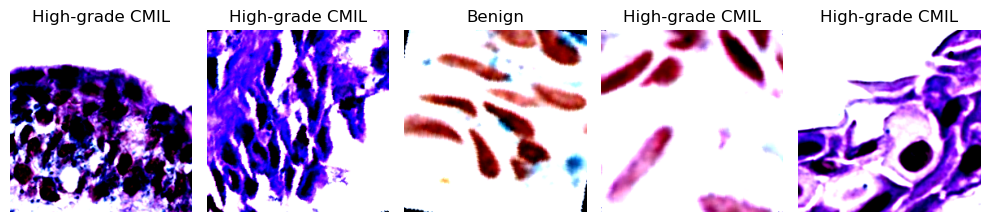

In [8]:

# Load labels

labels = pd.read_csv('/Users/harveywang/Downloads/case_grade_match.csv')  # Replace with your path

# Group patches by case
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)
        if match:
            case_num = int(match.group(1))
            case_patches.setdefault(case_num, []).append(os.path.join(patch_dir, filename))
    return case_patches

# Dataset definition

class PNGDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None):
        self.case_patches = case_patches
        self.labels_df = labels_df
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for case_num, patches in case_patches.items():
            label = labels_df.loc[labels_df['Case'] == case_num, 'Class'].values[0]
            label = 0 if label == 1 else 1  # Label benign as 0, high-grade CMIL as 1
            for patch_path in patches:
                self.image_paths.append(patch_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load and split data

image_folder_path = '/Users/harveywang/Library/CloudStorage/GoogleDrive-harveywang2026@u.northwestern.edu/My Drive/Northwestern/Coursework/2025 Spring/STAT 390/filtered_patches'  # Replace with your path
patches = group_patches(image_folder_path)

case_nums = list(patches.keys())
dataset = labels.loc[[(int(x)-1) for x in case_nums]]

dataset = dataset[dataset.Class != 2.0]  # Remove low-grade CMIL
X = dataset.Case.reset_index(drop=True)
y = dataset.Class.reset_index(drop=True)

train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
train_X, val_X, y_train, y_val = train_test_split(train_X, y_train, test_size=0.2, stratify=y_train, random_state=40)

train_patches = {case_num: patches[int(case_num)] for case_num in train_X}
val_patches = {case_num: patches[int(case_num)] for case_num in val_X}
test_patches = {case_num: patches[int(case_num)] for case_num in test_X}

train_dataset = PNGDataset(train_patches, labels, transform=train_transform)
val_dataset = PNGDataset(val_patches, labels, transform=eval_transform)
test_dataset = PNGDataset(test_patches, labels, transform=eval_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Visualize training samples

images, labels = next(iter(train_loader))
fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
for i in range(5):
    axes[i].imshow(images[i].permute(1, 2, 0))
    axes[i].set_title('Benign' if labels[i] == 0 else 'High-grade CMIL')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [9]:
# Define validation loss and accuracy

def validation(model, criterion, val_loader):
    val_loss = 0
    accuracy = 0

    for images, labels in iter(val_loader):
        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)

        equality = labels.data == probabilities.max(dim=1)[1]
        accuracy += equality.type(torch.FloatTensor).mean()

    return val_loss, accuracy

In [10]:
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_acc = 0  # Track best validation accuracy

    # Create local directory to save model checkpoints
    os.makedirs("./models", exist_ok=True)

    model.to(device)

    for e in range(epochs):
        model.train()
        running_loss = 0

        # tqdm progress bar: leave=True for Jupyter
        train_bar = tqdm(train_loader, desc=f"Epoch {e+1}/{epochs}", leave=True)
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_bar.set_postfix(loss=running_loss / (train_bar.n + 1))

        epoch_train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        with torch.no_grad():
            validation_loss = 0
            correct = 0
            total = 0

            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            avg_val_loss = validation_loss / len(val_loader)
            val_accuracy = correct / total

        print(
            f"Epoch: {e+1}/{epochs}.. "
            f"Train Loss: {epoch_train_loss:.3f}.. "
            f"Val Loss: {avg_val_loss:.3f}.. "
            f"Val Accuracy: {val_accuracy:.3f}"
        )

        # Save model checkpoint for this epoch
        torch.save({
            'epoch': e + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy
        }, f"./models/model_epoch_{e+1}.pth")

        # Save best model if validation accuracy improves
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), "./models/best_model.pth")
            print(f"✅ New best model saved at epoch {e+1} with accuracy {val_accuracy:.4f}")

        # Store metrics for plots
        train_losses.append(epoch_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

    # Plot training curves
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy During Training')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [11]:
def save_checkpoint(model, class_mapping, arch):
    """
    Save trained model weights.

    Input:
    arch(str): Model architecture
    """

    checkpoint = {
        "arch": arch,
        "class_to_idx": class_mapping,
        "model_state_dict": model.state_dict(),
    }

    timestamp = datetime.now().date().strftime("%Y%m%d")
    torch.save(checkpoint, f"../checkpoint/{timestamp}_{arch}.pth")
     

In [12]:
#1. Load pretrained EfficientNet-B2
model = models.efficientnet_b2(weights="IMAGENET1K_V1")  # torchvision >= 0.13 syntax

# 2. Freeze all pretrained parameters
for parameter in model.parameters():
    parameter.requires_grad = False

# 3. Build custom classifier
num_classes = 2
num_ftrs = model.classifier[1].in_features  # EfficientNet has a classifier with [Dropout, Linear]

classifier = nn.Sequential(
    OrderedDict(
        [
            ("fc", nn.Linear(num_ftrs, num_classes)),
            ("output", nn.LogSoftmax(dim=1)),
        ]
    )
)

# 4. Replace EfficientNet's classifier
model.classifier = classifier

# 5. Move to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("\n Modified EfficientNet classifier:")
print(model.classifier)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /Users/harveywang/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
python(37524) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 35.2M/35.2M [00:04<00:00, 8.38MB/s]



 Modified EfficientNet classifier:
Sequential(
  (fc): Linear(in_features=1408, out_features=2, bias=True)
  (output): LogSoftmax(dim=1)
)


In [13]:
# Loss function: CrossEntropyLoss (expects raw logits)
criterion = nn.CrossEntropyLoss()

# Optimizer: only update the classifier (model.classifier.parameters())
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

Epoch 1/5: 100%|██████████| 303/303 [4:48:59<00:00, 57.23s/it, loss=0.52]   


Epoch: 1/5.. Train Loss: 0.520.. Val Loss: 0.598.. Val Accuracy: 0.723
✅ New best model saved at epoch 1 with accuracy 0.7228


Epoch 2/5: 100%|██████████| 303/303 [16:09<00:00,  3.20s/it, loss=0.48] 


Epoch: 2/5.. Train Loss: 0.480.. Val Loss: 0.618.. Val Accuracy: 0.718


Epoch 3/5: 100%|██████████| 303/303 [17:58<00:00,  3.56s/it, loss=0.472]


Epoch: 3/5.. Train Loss: 0.472.. Val Loss: 0.622.. Val Accuracy: 0.721


Epoch 4/5: 100%|██████████| 303/303 [18:11<00:00,  3.60s/it, loss=0.458]


Epoch: 4/5.. Train Loss: 0.458.. Val Loss: 0.633.. Val Accuracy: 0.692


Epoch 5/5: 100%|██████████| 303/303 [18:24<00:00,  3.65s/it, loss=0.45] 


Epoch: 5/5.. Train Loss: 0.450.. Val Loss: 0.637.. Val Accuracy: 0.700


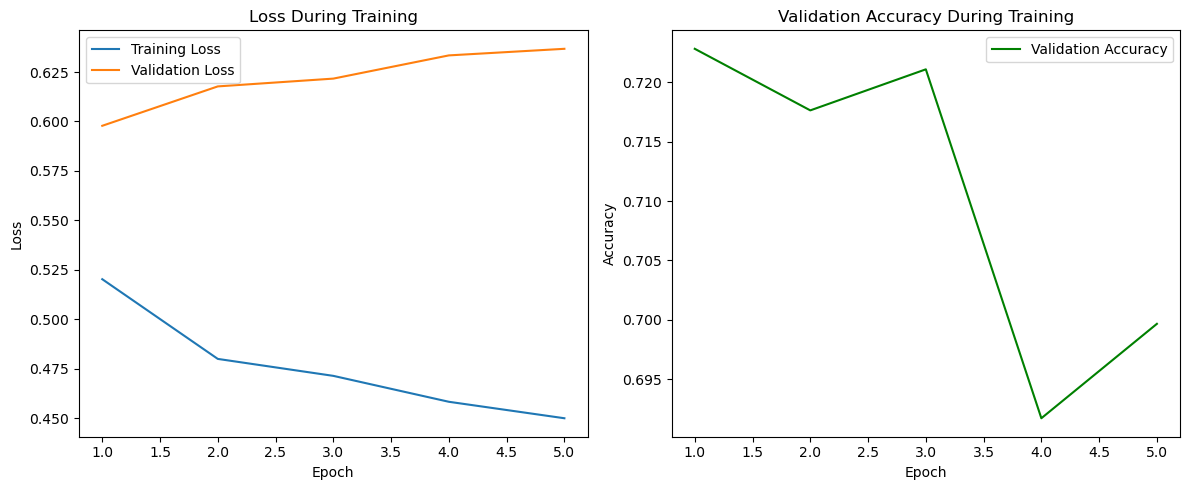

In [14]:
# Train model for 5 epochs
efficientnet_model = train_model(model, optimizer, criterion, train_loader, val_loader)

In [ ]:
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Benign', 'High-grade CMIL'],
            yticklabels=['Benign', 'High-grade CMIL'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()